<a href="https://colab.research.google.com/github/divyanshuraj6815/EVA6/blob/main/Experiment_7/experiment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

!pip install albumentations==0.4.6

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
!rm -r EVA6
!git clone https://github.com/divyanshuraj6815/EVA6.git

Cloning into 'EVA6'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 174 (delta 76), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (174/174), 1.82 MiB | 16.79 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [ ]:
from EVA6.Experiment_7.model import Net
from EVA6.Experiment_7.get_mean_and_std import get_mean_std
from EVA6.Experiment_7.train_test_module import train, test

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

get_mean_std (trainloader)

Files already downloaded and verified


(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]), 391)

In [ ]:
train_transform = A.Compose ([
    A.HorizontalFlip (),
    A.ShiftScaleRotate (shift_limit = 0.05, scale_limit = 0.1, rotate_limit = 15, p = 0.5),
    A.CoarseDropout (max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), p=0.4),
    A.Normalize (mean = (0.4914, 0.4822, 0.4465), std = (0.2470, 0.2435, 0.2616)),
    ToTensorV2()
])
test_transform = A.Compose ([
    A.Normalize (mean = (0.4914, 0.4822, 0.4465), std = (0.2470, 0.2435, 0.2616)),
    ToTensorV2()
])

In [ ]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [ ]:
trainset = Cifar10SearchDataset(train = True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = Cifar10SearchDataset(train = False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                          shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

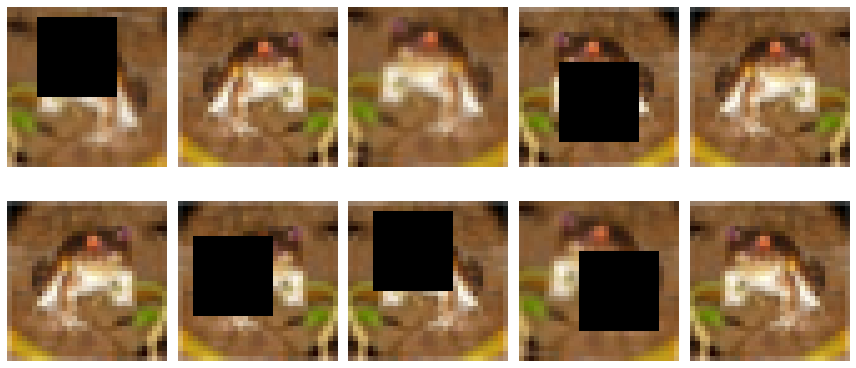

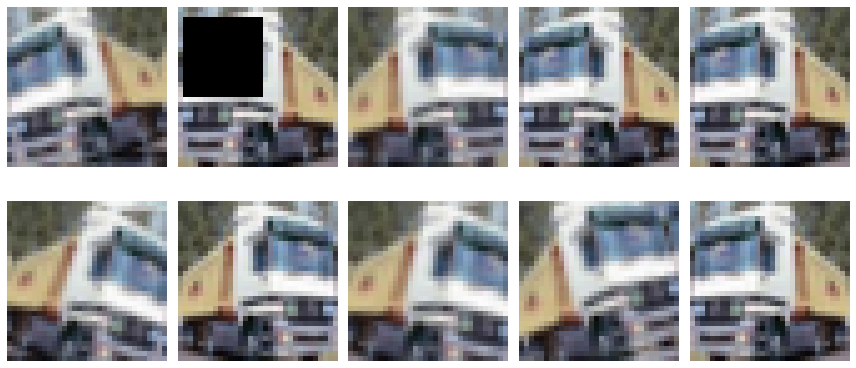

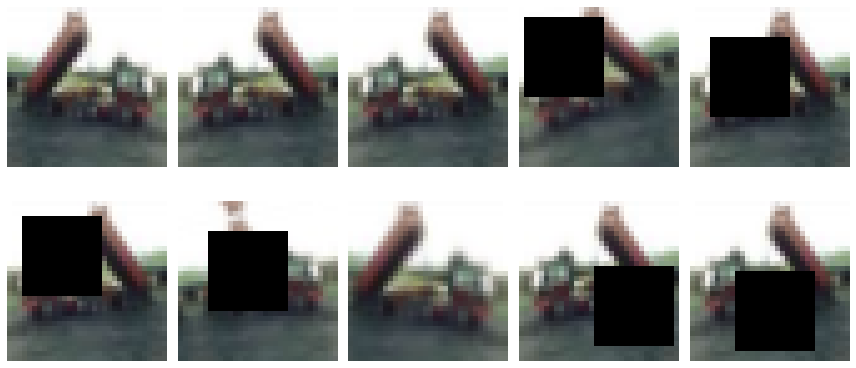

In [ ]:
random.seed(42)
visualize_augmentations(trainset, idx = 0)
visualize_augmentations(trainset, idx = 1)
visualize_augmentations(trainset, idx = 2)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         LeakyReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             320
            Conv2d-6           [-1, 32, 32, 32]           1,056
         LeakyReLU-7           [-1, 32, 32, 32]               0
       BatchNorm2d-8           [-1, 32, 32, 32]              64
           Dropout-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 32, 15, 15]             320
           Conv2d-11           [-1, 32, 15, 15]           1,056
        LeakyReLU-12           [-1, 32, 15, 15]               0
      BatchNorm2d-13           [-1, 32, 15, 15]              64
          Dropout-14           [-1

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr = 0.4, epochs = 40, steps_per_epoch = 391)

EPOCHS = 40
count = 0
flag = 1
train_losses = []
train_accs = []
test_losses = []
test_accs = []
learning_rate = []

for epoch in range(EPOCHS):
    print("EPOCH:", epoch, scheduler.get_lr ())
    learning_rate.append (scheduler.get_lr ())
    (train_loss, train_acc) = train(model, device, trainloader, optimizer, epoch, scheduler)
    train_losses += train_loss
    train_accs += train_acc

    (test_loss, test_acc) = test(model, device, testloader)
    test_losses += test_loss
    test_accs += test_acc

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1290: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0 [0.016000000000000014]


Loss=1.4740521907806396 Batch_id=390 Accuracy=35.04: 100%|██████████| 391/391 [00:10<00:00, 36.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Accuracy: 4801/10000 (48.01%)

EPOCH: 1 [0.022545014965587973]


Loss=1.385848045349121 Batch_id=390 Accuracy=45.78: 100%|██████████| 391/391 [00:10<00:00, 36.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 4890/10000 (48.90%)

EPOCH: 2 [0.041733838811312596]


Loss=1.441720724105835 Batch_id=390 Accuracy=49.64: 100%|██████████| 391/391 [00:10<00:00, 36.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 5656/10000 (56.56%)

EPOCH: 3 [0.07225823050339986]


Loss=1.4292752742767334 Batch_id=390 Accuracy=52.55: 100%|██████████| 391/391 [00:10<00:00, 36.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 6039/10000 (60.39%)

EPOCH: 4 [0.11203712128726467]


Loss=1.2037606239318848 Batch_id=390 Accuracy=55.26: 100%|██████████| 391/391 [00:10<00:00, 36.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 6220/10000 (62.20%)

EPOCH: 5 [0.1583584962098352]


Loss=1.2928862571716309 Batch_id=390 Accuracy=57.64: 100%|██████████| 391/391 [00:10<00:00, 36.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 6336/10000 (63.36%)

EPOCH: 6 [0.20806429181179034]


Loss=0.9707684516906738 Batch_id=390 Accuracy=59.92: 100%|██████████| 391/391 [00:10<00:00, 36.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6862/10000 (68.62%)

EPOCH: 7 [0.25776570417551287]


Loss=0.9850913286209106 Batch_id=390 Accuracy=62.36: 100%|██████████| 391/391 [00:10<00:00, 36.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 6772/10000 (67.72%)

EPOCH: 8 [0.30407422822046715]


Loss=0.8237504959106445 Batch_id=390 Accuracy=64.29: 100%|██████████| 391/391 [00:10<00:00, 36.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 7167/10000 (71.67%)

EPOCH: 9 [0.34383267662468936]


Loss=0.8159632682800293 Batch_id=390 Accuracy=65.59: 100%|██████████| 391/391 [00:10<00:00, 36.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 7289/10000 (72.89%)

EPOCH: 10 [0.37433042814011513]


Loss=1.0770630836486816 Batch_id=390 Accuracy=66.97: 100%|██████████| 391/391 [00:10<00:00, 36.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7408/10000 (74.08%)

EPOCH: 11 [0.3934882302658565]


Loss=0.921371340751648 Batch_id=390 Accuracy=68.03: 100%|██████████| 391/391 [00:10<00:00, 36.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 7453/10000 (74.53%)

EPOCH: 12 [0.399999991765667]


Loss=0.9080082178115845 Batch_id=390 Accuracy=69.08: 100%|██████████| 391/391 [00:10<00:00, 36.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7627/10000 (76.27%)

EPOCH: 13 [0.3987360130798167]


Loss=0.7294307351112366 Batch_id=390 Accuracy=69.85: 100%|██████████| 391/391 [00:10<00:00, 36.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7783/10000 (77.83%)

EPOCH: 14 [0.3949728237806312]


Loss=0.7591437101364136 Batch_id=390 Accuracy=71.09: 100%|██████████| 391/391 [00:10<00:00, 36.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7849/10000 (78.49%)

EPOCH: 15 [0.38875774815700104]


Loss=1.0178992748260498 Batch_id=390 Accuracy=71.09: 100%|██████████| 391/391 [00:10<00:00, 36.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7821/10000 (78.21%)

EPOCH: 16 [0.38016894439096427]


Loss=0.6819766759872437 Batch_id=390 Accuracy=72.16: 100%|██████████| 391/391 [00:10<00:00, 36.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7877/10000 (78.77%)

EPOCH: 17 [0.3693144216732188]


Loss=0.8393912315368652 Batch_id=390 Accuracy=72.35: 100%|██████████| 391/391 [00:10<00:00, 35.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8005/10000 (80.05%)

EPOCH: 18 [0.35633068192488104]


Loss=0.7435797452926636 Batch_id=390 Accuracy=73.09: 100%|██████████| 391/391 [00:10<00:00, 36.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7807/10000 (78.07%)

EPOCH: 19 [0.3413810032066277]


Loss=0.8651952743530273 Batch_id=390 Accuracy=73.61: 100%|██████████| 391/391 [00:10<00:00, 35.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8063/10000 (80.63%)

EPOCH: 20 [0.3246533864023463]


Loss=0.6992658376693726 Batch_id=390 Accuracy=74.00: 100%|██████████| 391/391 [00:10<00:00, 36.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8101/10000 (81.01%)

EPOCH: 21 [0.3063581909989402]


Loss=0.7866331338882446 Batch_id=390 Accuracy=74.30: 100%|██████████| 391/391 [00:10<00:00, 36.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8140/10000 (81.40%)

EPOCH: 22 [0.2867254896937267]


Loss=0.8524472117424011 Batch_id=390 Accuracy=74.75: 100%|██████████| 391/391 [00:10<00:00, 35.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8168/10000 (81.68%)

EPOCH: 23 [0.26600217509677754]


Loss=0.7211383581161499 Batch_id=390 Accuracy=75.03: 100%|██████████| 391/391 [00:10<00:00, 35.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8173/10000 (81.73%)

EPOCH: 24 [0.24444885491309665]


Loss=0.567195475101471 Batch_id=390 Accuracy=75.82: 100%|██████████| 391/391 [00:10<00:00, 35.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8161/10000 (81.61%)

EPOCH: 25 [0.22233657464952136]


Loss=0.8059312701225281 Batch_id=390 Accuracy=76.08: 100%|██████████| 391/391 [00:10<00:00, 36.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8260/10000 (82.60%)

EPOCH: 26 [0.19994340906021002]


Loss=0.8164244890213013 Batch_id=390 Accuracy=76.91: 100%|██████████| 391/391 [00:10<00:00, 35.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8306/10000 (83.06%)

EPOCH: 27 [0.17755096519526556]


Loss=0.5578606128692627 Batch_id=390 Accuracy=77.10: 100%|██████████| 391/391 [00:10<00:00, 36.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8339/10000 (83.39%)

EPOCH: 28 [0.15544084102868813]


Loss=0.5798834562301636 Batch_id=390 Accuracy=77.37: 100%|██████████| 391/391 [00:10<00:00, 35.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8355/10000 (83.55%)

EPOCH: 29 [0.13389108420046542]


Loss=0.6583885550498962 Batch_id=390 Accuracy=77.94: 100%|██████████| 391/391 [00:10<00:00, 35.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8373/10000 (83.73%)

EPOCH: 30 [0.11317269540617247]


Loss=0.6109524965286255 Batch_id=390 Accuracy=78.59: 100%|██████████| 391/391 [00:10<00:00, 36.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8429/10000 (84.29%)

EPOCH: 31 [0.09354622040598659]


Loss=0.6900486350059509 Batch_id=390 Accuracy=78.94: 100%|██████████| 391/391 [00:10<00:00, 35.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8482/10000 (84.82%)

EPOCH: 32 [0.07525847351058124]


Loss=0.419482558965683 Batch_id=390 Accuracy=79.48: 100%|██████████| 391/391 [00:11<00:00, 35.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8476/10000 (84.76%)

EPOCH: 33 [0.05853943374796401]


Loss=0.4741341471672058 Batch_id=390 Accuracy=79.56: 100%|██████████| 391/391 [00:10<00:00, 35.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8526/10000 (85.26%)

EPOCH: 34 [0.04359935274376268]


Loss=0.7262353301048279 Batch_id=390 Accuracy=80.41: 100%|██████████| 391/391 [00:10<00:00, 35.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8547/10000 (85.47%)

EPOCH: 35 [0.03062611068504198]


Loss=0.6374956965446472 Batch_id=390 Accuracy=80.77: 100%|██████████| 391/391 [00:10<00:00, 35.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8548/10000 (85.48%)

EPOCH: 36 [0.01978285361794066]


Loss=0.6033517718315125 Batch_id=390 Accuracy=81.15: 100%|██████████| 391/391 [00:10<00:00, 35.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8571/10000 (85.71%)

EPOCH: 37 [0.011205941791481858]


Loss=0.7381899356842041 Batch_id=390 Accuracy=81.35: 100%|██████████| 391/391 [00:11<00:00, 35.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8598/10000 (85.98%)

EPOCH: 38 [0.0050032348483234415]


Loss=0.6880630254745483 Batch_id=390 Accuracy=81.48: 100%|██████████| 391/391 [00:10<00:00, 35.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8598/10000 (85.98%)

EPOCH: 39 [0.0012527354271700075]


Loss=0.64747154712677 Batch_id=390 Accuracy=81.50: 100%|██████████| 391/391 [00:11<00:00, 35.42it/s]



Test set: Average loss: 0.0032, Accuracy: 8592/10000 (85.92%)



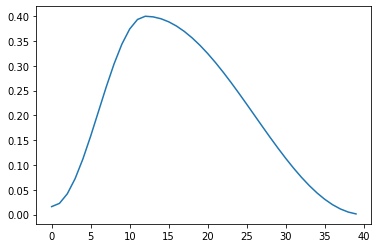

In [ ]:
plt.plot (learning_rate)

Text(0.5, 1.0, 'Test Accuracy')

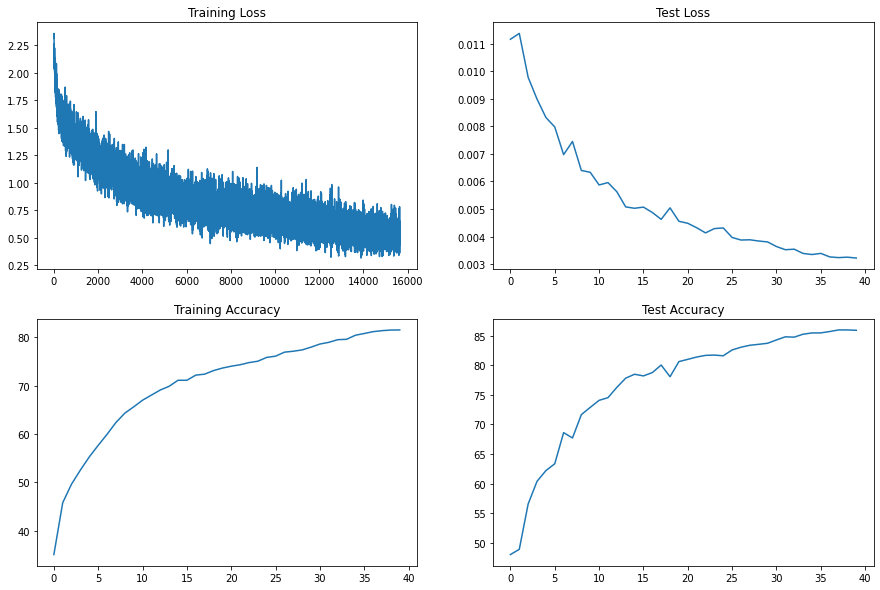

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accs)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accs)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
correct = []
wrong = []
model = model.to(device)
for i in range (20):
  images, labels = next (iter (testloader))

  img = images
  # Turn off gradients to speed up this part
  with torch.no_grad():
      logps = model (img.cuda())

  # Output of the network are log-probabilities, need to take exponential for probabilities
  ps = torch.exp (logps)
  probabs = []
  for j, element in enumerate (ps):
      pred = torch.argmax(element)
      if pred == labels[j].item ():
          correct.append ([img[j], ps[j], pred, labels[j].item ()])
      else:
          wrong.append ([img[j], ps[j], pred, labels[j].item ()])

len (correct), len (wrong)

(2212, 348)

In [ ]:
import numpy as np
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.permute(1,2,0)) #(height,width,dim)
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

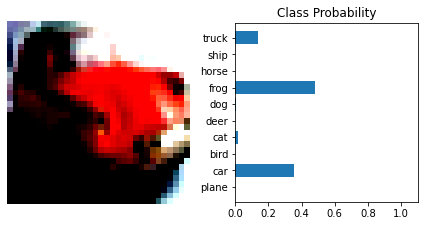

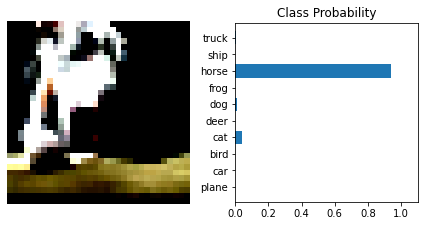

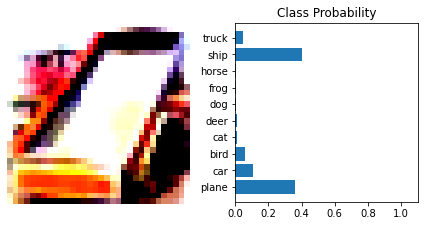

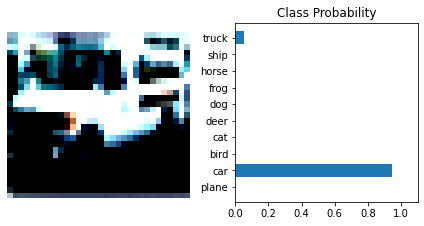

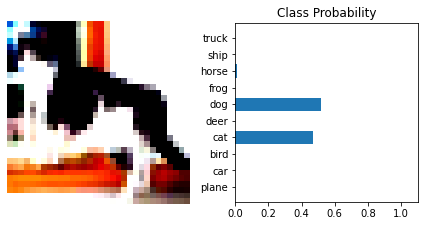

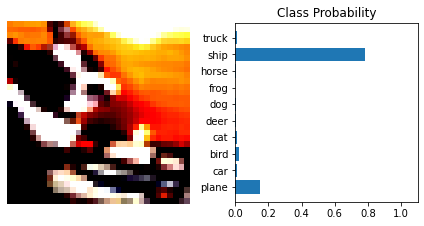

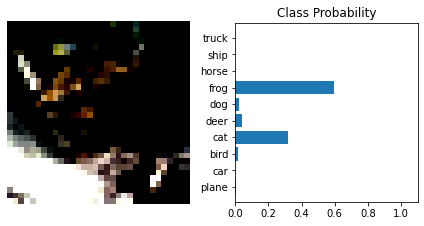

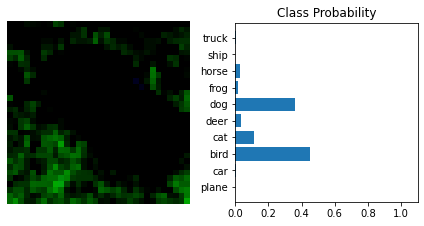

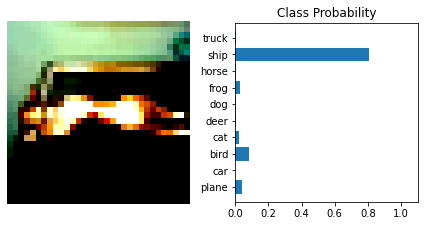

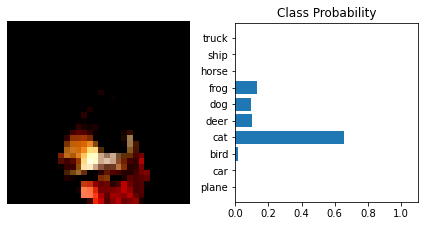

In [ ]:
for i in range (10):
  #print (wrong[i][0].shape)
  view_classify (wrong[i][0], wrong[i][1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

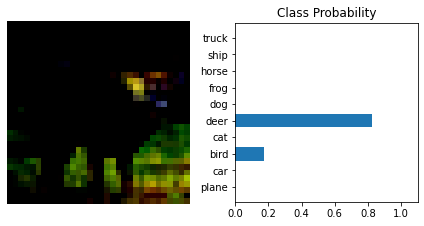

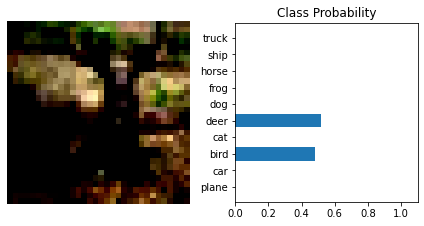

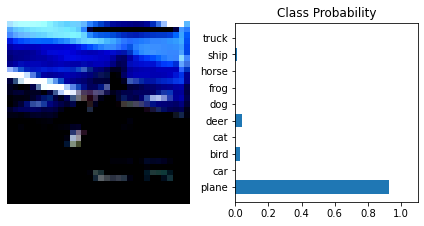

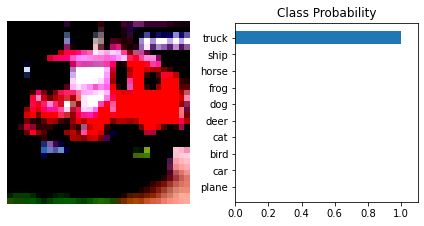

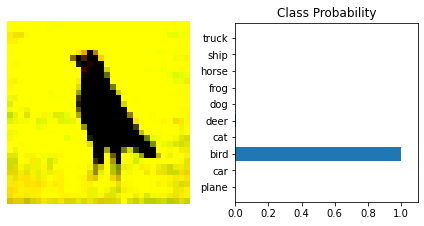

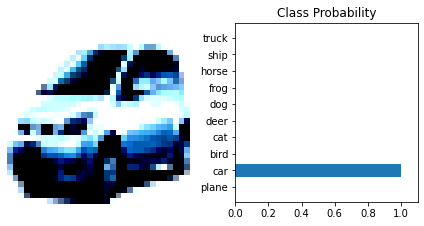

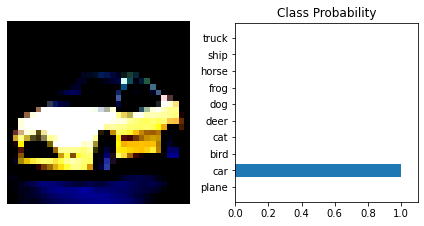

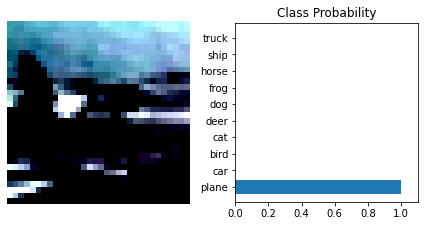

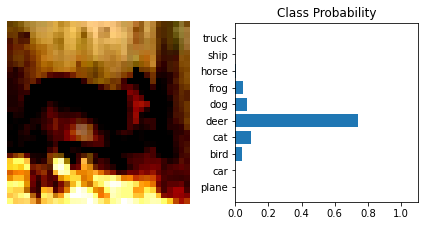

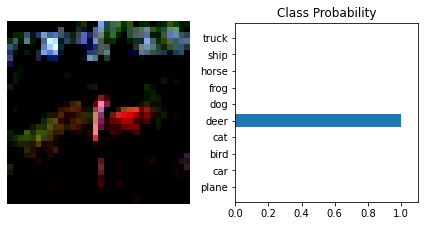

In [ ]:
for i in range (10):
  #print (wrong[i][0].shape)
  view_classify (correct[i][0], correct[i][1])

In [ ]:
model = model.to ('cpu')
outputs = model(images)

In [ ]:
correct = 0
correcta = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 94 %
Accuracy of  bird : 82 %
Accuracy of   cat : 70 %
Accuracy of  deer : 85 %
Accuracy of   dog : 76 %
Accuracy of  frog : 91 %
Accuracy of horse : 87 %
Accuracy of  ship : 94 %
Accuracy of truck : 91 %
